In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Problem Statement:

Using the Speed Dating Data provided by Kaggle, determine how likely a participant will choose to see a person again (Dec=1) based on how the aspects of the participant's perception of the person and their background (attr, sinc. intel. fun, amb, shar, like, prob, met, career etc)

In [2]:
#df.columns.get_loc('attr1_s')
df = pd.read_csv('Speed Dating Data.csv', usecols= [i for i in range(108)])

### Data Dictionary:


FieldName|Description
---------|-----------------------------------------------------------------------------------
gender|Female=0 Male=1
order|the number of date that night when met partner
int_corr|correlation between participant’s and partner’s ratings of interests in Time 1
samerace|participant and the partner were the same race. 1= yes, 0=no
age_o|age of partner
race|Black/African American=1
	|European/Caucasian-American=2
	|Latino/Hispanic American=3
	|Asian/Pacific Islander/Asian-American=4
	|Native American=5
	|Other=6
imprace|How important is it to you (on a scale of 1-10) that a person you date be of the same racial/ethnic background?
imprelig|How important is it to you (on a scale of 1-10) that a person you date be of the same religious background?
dec|Decision: 1=Yes 2=No
goal|What is your primary goal in participating in this event? 
	|Seemed like a fun night out=1
	|To meet new people=2
	|To get a date=3
	|Looking for a serious relationship=4
	|To say I did it=5
	|Other=6
date|In general, how frequently do you go on dates? 
	|Several times a week=1
	|Twice a week=2
	|Once a week=3
    |Twice a month=4
	|Once a month=5
	|Several times a year=6
	|Almost never=7
go_out|How often do you go out (not necessarily on dates)?
	|Several times a week=1
	|Twice a week=2
	|Once a week=3
	|Twice a month=4
	|Once a month=5
	|Several times a year=6
	|Almost never=7
career_c|career coded 
    |1= Lawyer 
    |2= Academic/Research 
    |3= Psychologist 
    |4= Doctor/Medicine 
    |5=Engineer 
    |6= Creative Arts/Entertainment 
    |7= Banking/Consulting/Finance/Marketing/Business/CEO/Entrepreneur/Admin 
    |8= Real Estate 
    |9= International/Humanitarian Affairs 
    |10= Undecided 
    |11=Social Work
    |12=Speech Pathology
    |13=Politics
    |14=Pro sports/Athletics
    |15=Other
    |16=Journalism
    |17=Architecture
attr|Rate attraction of partner 1-10
sinc|Rate sincerity of partner 1-10
intel|Rate intelligence of partner 1-10
fun|Rate fun(ness) of partner 1-10
amb|Rate ambition of partner 1-10
shar|Rate shared interest of partner 1-10
like|Overall, how much do you like this person? (1=don't like at all, 10=like a lot)
prob|How probable do you think it is that this person will say 'yes' for you? (1=not probable, 10=extremely probable)
met|Have you met this partner before: 1=Yes 2=No

In [3]:
#Since the data has so many features, remove cols not needed for analysis
col_to_drop = ['id', 'iid', 'idg', 'condtn', 'wave', 'round', 'position', 'positin1', 'partner', 'met_o', \
               'race_o', 'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o', 'shar_o', 'like_o', \
               'prob_o', 'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun', 'pf_o_amb', 'pf_o_sha', \
               'age', 'field_cd', 'field', 'undergra', 'career', 'pid', 'match', 'from', 'zipcode', \
               'mn_sat', 'tuition', 'income'] #might keep income
first_part = df.iloc[:, :df.columns.get_loc('career_c' )+1].drop(col_to_drop, axis=1)
second_part = df.iloc[:, df.columns.get_loc('dec'):df.columns.get_loc('met')+1]

df = first_part.join(second_part)

### Exploring and Cleaning the Data:

#### Taking a closer look at the dataset

In [4]:
#print df.describe()

In [5]:
"""for a in df.columns.values: 
    tempdf = df[a]
    print tempdf.value_counts().sort_values()"""

df.met.value_counts().sort_index()

0.0    4047
1.0     351
2.0    3597
3.0       1
5.0       2
6.0       1
7.0       3
8.0       1
Name: met, dtype: int64

In [6]:
#decided to drop this variable; should be only 1's and 2's so it seems too problematic
df.drop('met', axis=1, inplace=True)

#### Prevalence/Bias

In [7]:
pd.crosstab(df.dec, 'percentage', normalize='columns')

col_0,percentage
dec,
0,0.580091
1,0.419909


### Graphs

#### Distribution of outcome in dataset

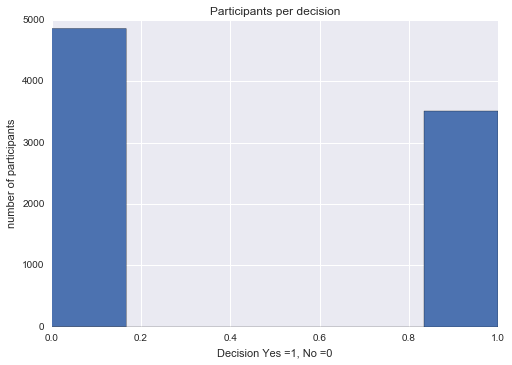

In [8]:
plt.hist(df.dec, bins=6)
plt.xlabel('Decision Yes =1, No =0')
plt.ylabel('number of participants')
plt.title('Participants per decision')

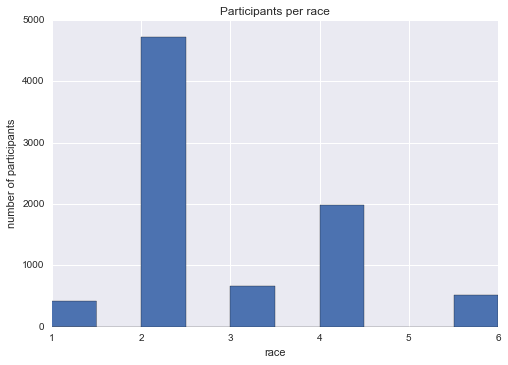

In [9]:
plt.hist(df.race.dropna())
plt.xlabel('race')
plt.ylabel('number of participants')
plt.title('Participants per race')

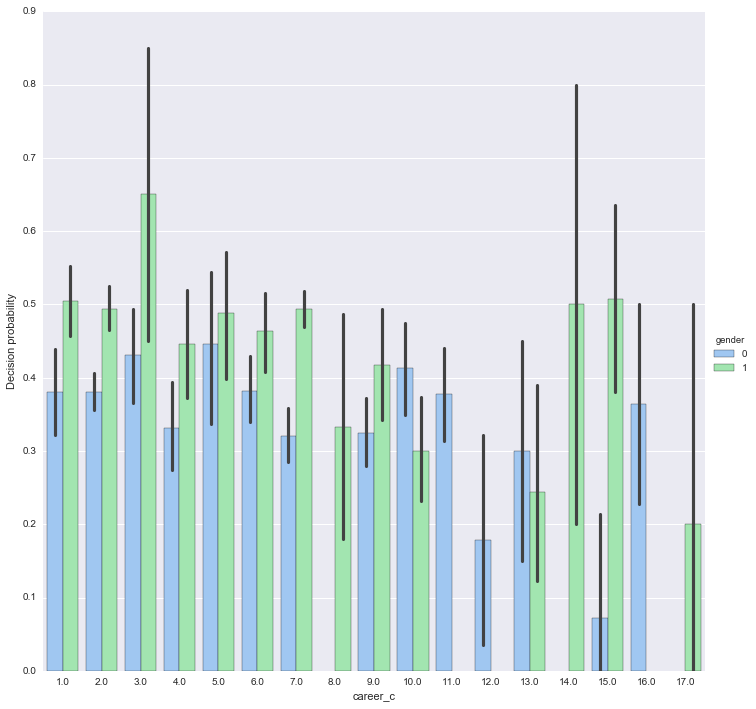

In [10]:
g = sns.factorplot(x="career_c", y="dec", hue="gender", data=df,
                   size=10, kind="bar", palette="pastel")
g.despine(left=True)
g.set_ylabels("Decision probability")

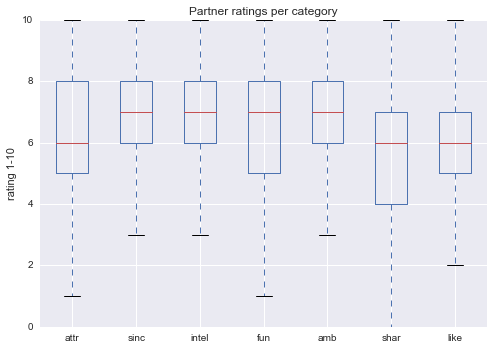

In [11]:
df[['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like']].plot(kind='box')
plt.ylabel('rating 1-10') 
plt.title('Partner ratings per category')

order        1         5         9         13        17        21
dec                                                              
0      0.056790  0.065432  0.057407  0.045473  0.032510  0.011728
1      0.078169  0.066231  0.063388  0.042922  0.027004  0.008243


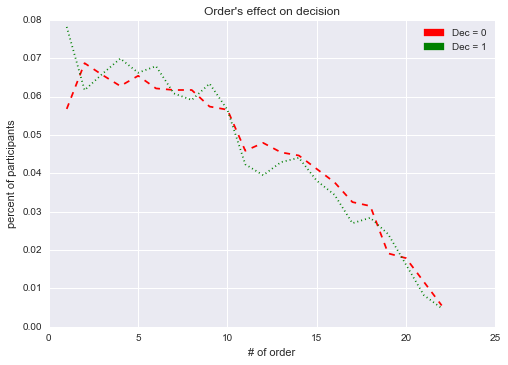

In [12]:
import matplotlib.patches as mpatches

ordr = pd.crosstab(df.order, df.dec, normalize='columns')
print ordr.T.loc[:,::4]
plt.plot(ordr[0], 'r--', ordr[1], 'g:')
plt.xlabel('# of order')
plt.ylabel('percent of participants')
plt.title('Order\'s effect on decision')

red_patch = mpatches.Patch(color='red', label='Dec = 0')
green_patch = mpatches.Patch(color='green', label='Dec = 1')
plt.legend(handles=[red_patch, green_patch])

#### Use LogisticRegression to see the probability of Deciding to see someone again given their ranking for the person in the categories

In [13]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

features = ['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'prob', 'dec']
ranks = df.loc[:,features].dropna().astype(int)

y = ranks.dec
X = ranks.drop('dec', axis=1)
X = sm.add_constant(X, prepend = True)

logit_mod = sm.Logit(y, X)
logit_res = logit_mod.fit(disp=0)
logit_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    dec   No. Observations:                 6963
Model:                          Logit   Df Residuals:                     6954
Method:                           MLE   Df Model:                            8
Date:                Sun, 20 Nov 2016   Pseudo R-squ.:                  0.3059
Time:                        13:21:24   Log-Likelihood:                -3304.4
converged:                       True   LL-Null:                       -4760.4
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -6.0332      0.206    -29.249      0.000        -6.438    -5.629
attr           0.4347      0.023     18.622      0.000         0.389     0.480
sinc          -0.2083      0.027     -7.738      0.000        -0.261    -0.156
intel         -0.0126      0.032     -0.393      0.694        -0.076     0.050
fun            0.1410      0.026      5.530      0.000         0.091     0.191
amb           -0.1823      0.025     -7.335      0.000        -0.231    -0.134
shar           0.1139      0.021      5.522      0.000         0.073     0.154
like           0.5494      0.032     17.166      0.000         0.487     0.612
prob           0.1425      0.018      8.105      0.000         0.108     0.177
==============================================================================
"""

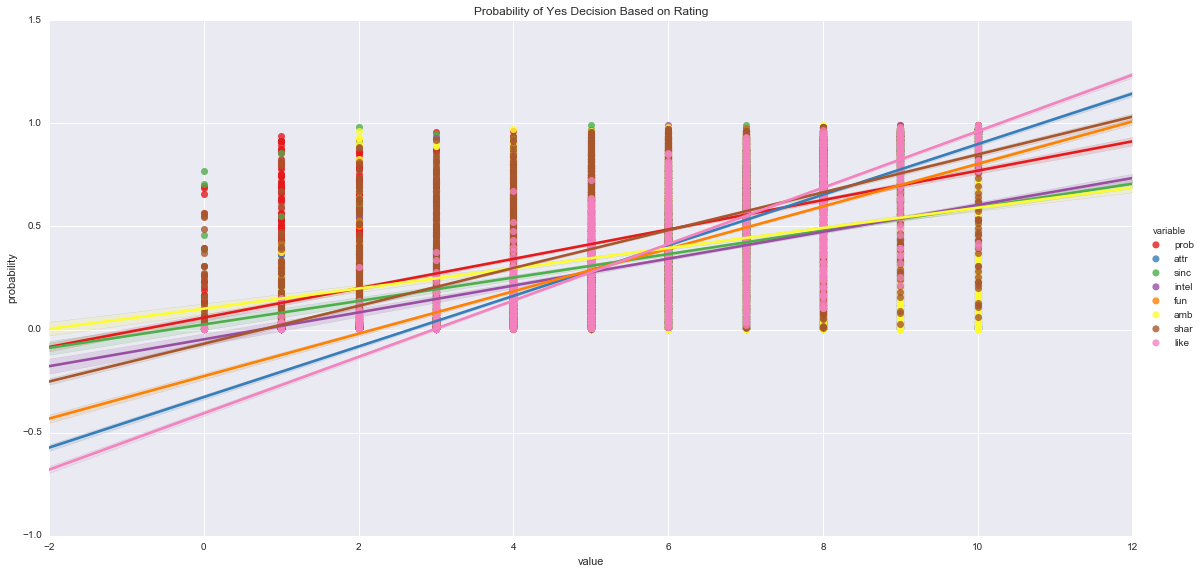

In [14]:
features = ['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'prob', 'dec']
ranks = df.loc[:,features].dropna().astype(int)

y = ranks.dec
X = ranks.drop('dec', axis=1)

lr = LogisticRegression(fit_intercept=True)
lr.fit(X, y)
ranks['probability'] = lr.predict_proba(ranks.drop('dec', axis=1)).T[1]

ranks = pd.melt(ranks, id_vars=['probability'], \
                value_vars=['prob', 'attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like'])

sns.lmplot('value', 'probability', 
           data=ranks, size=8, aspect=2,
           fit_reg=True, hue='variable',
           scatter_kws={'s': 50, 'marker': '.'}, palette='Set1')
plt.gca().set(title='Probability of Yes Decision Based on Rating')

You can observe from the graph above that all the rankings generally have an direct relationship with the probability of a Decision=1, so the higher the rank the more likely the participant is to say Yes

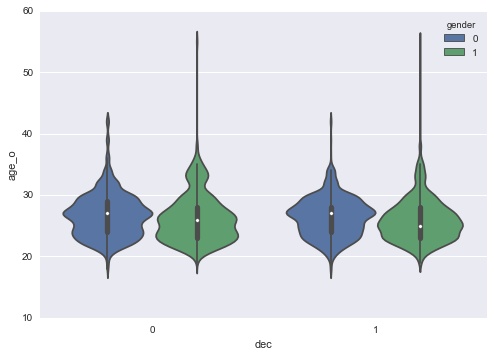

In [15]:
sns.violinplot(x='dec', y='age_o', hue='gender', data=df)

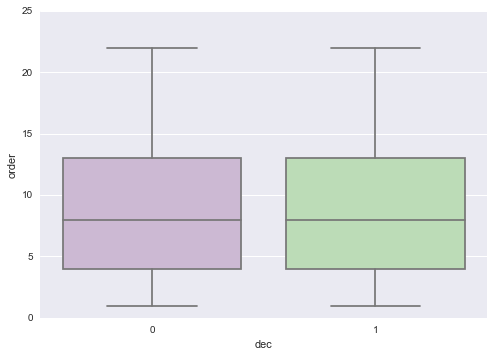

In [16]:
sns.boxplot(x='dec', y='order', data=df, palette='PRGn')

#### Heatmap of correlations between numerical variables

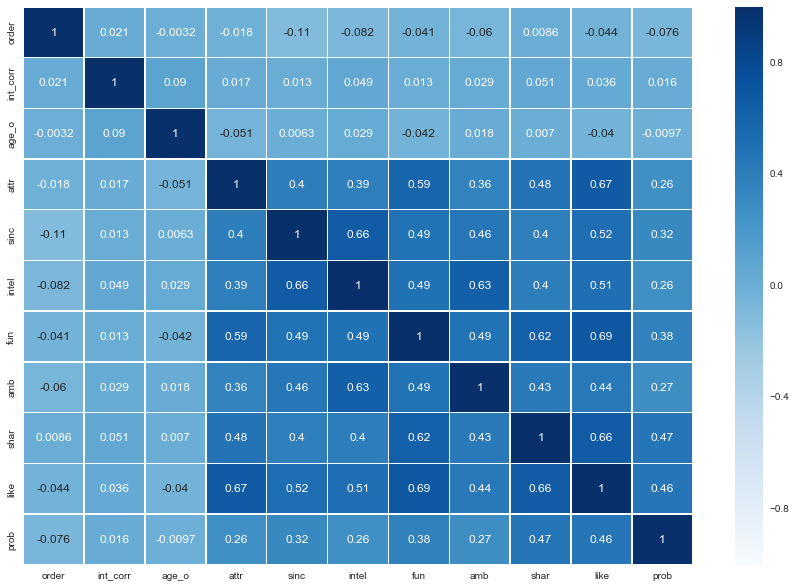

In [17]:
categoricals = ['gender', 'samerace', 'race', 'imprace', 'imprelig', 'goal', 'date', 'go_out', 'career_c']
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df.drop(categoricals, axis=1).drop('dec', axis=1).corr(), annot=True, linewidths=0.5, cmap="Blues")

#### Handling NULL values

In [18]:
#NULL VALUES
pd.DataFrame({'mean': df.mean(),  'median': df.median(), 'null_amt': df.isnull().sum()})

,mean,median,null_amt
gender,0.500597,1.00,0
order,8.927668,8.00,0
int_corr,0.196010,0.21,158
samerace,0.395799,0.00,0
age_o,26.364999,26.00,104
race,2.757186,2.00,63
imprace,3.784793,3.00,79
imprelig,3.651645,3.00,79
goal,2.122063,2.00,79
date,5.006762,5.00,97


In [19]:
#replacing NULL values for numerical columns with over under 400 NULLs with median
from sklearn.preprocessing import Imputer

cols_median = ['age_o', 'int_corr', 'imprace', 'imprelig']
imp = Imputer(missing_values='NaN', strategy='median', axis=0)
imp.fit(df[cols_median])
df[cols_median] = imp.transform(df[cols_median])

In [20]:
#replacing NULL values for categorical columns with over under 400 NULLs with mode

cols_mode = ['race', 'goal', 'date', 'go_out', 'career_c', 'attr', 'sinc', 'intel', 'fun', 'amb', 'like', 'prob']
imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
imp.fit(df[cols_mode])
df[cols_mode] = imp.transform(df[cols_mode])

In [21]:
#get dummies for categorical variables
for cols in ['race', 'goal', 'date', 'go_out', 'career_c']:
    df = df.join(pd.get_dummies(df[cols], prefix=cols, drop_first=True))
    df.drop(cols, axis=1)

In [22]:
corr = df.corr()
corr.where((abs(corr)>.5) & (corr<1))
#how to print out just column value, row value and actual value to save space and actually be able to see the values

,gender,order,int_corr,samerace,age_o,race,imprace,imprelig,goal,date,...,career_c_8.0,career_c_9.0,career_c_10.0,career_c_11.0,career_c_12.0,career_c_13.0,career_c_14.0,career_c_15.0,career_c_16.0,career_c_17.0
gender,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
int_corr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
samerace,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age_o,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
race,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
imprace,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
imprelig,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
goal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
#Shar has 1000+ nan values so use logisticregression to fill nan values
#Note: Shar does have 9 floats (.5's) out of 7000+ observations so it's only a small amount
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(fit_intercept=True)
X = df.dropna(subset=['shar']).drop('shar', axis=1)
y = df.shar.dropna().astype(int)
model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [24]:
df.loc[pd.isnull(df.shar), 'shar'] = model.predict(df.loc[pd.isnull(df.shar)].drop('shar', axis=1)) 
df.isnull().sum()

gender           0
order            0
int_corr         0
samerace         0
age_o            0
race             0
imprace          0
imprelig         0
goal             0
date             0
go_out           0
career_c         0
dec              0
attr             0
sinc             0
intel            0
fun              0
amb              0
shar             0
like             0
prob             0
race_2.0         0
race_3.0         0
race_4.0         0
race_6.0         0
goal_2.0         0
goal_3.0         0
goal_4.0         0
goal_5.0         0
goal_6.0         0
date_2.0         0
date_3.0         0
date_4.0         0
date_5.0         0
date_6.0         0
date_7.0         0
go_out_2.0       0
go_out_3.0       0
go_out_4.0       0
go_out_5.0       0
go_out_6.0       0
go_out_7.0       0
career_c_2.0     0
career_c_3.0     0
career_c_4.0     0
career_c_5.0     0
career_c_6.0     0
career_c_7.0     0
career_c_8.0     0
career_c_9.0     0
career_c_10.0    0
career_c_11.0    0
career_c_12.

In [25]:
"""convert floats to integers for rankings, similarly to df.shar, all rankings are generally integers
with <10 observations as floats (.5's) which skews the data"""
df[features] = df[features].astype(int)

### Analysis: Running the models

In [26]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import grid_search, cross_validation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

#### Quick test for base comparison

In [28]:
X = df.drop('dec', axis=1)
y = df['dec']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.80, random_state=333)

model = LogisticRegression(fit_intercept=True)
model.fit(X_train, y_train)
 
print model.score(X_test, y_test)
predicted = cross_validation.cross_val_predict(model, X, y, cv=10)
print metrics.accuracy_score(y, predicted)
print metrics.classification_report(y, predicted) 

0.766373265702
0.760324659823
             precision    recall  f1-score   support

          0       0.79      0.80      0.80      4860
          1       0.72      0.70      0.71      3518

avg / total       0.76      0.76      0.76      8378



#### Logistic Regression, KNeighbours Classifier and Random Forest Models:
try all three models and see which one is the better model

In [44]:
def roc_curve_plt(model, y_test, pred_proba):
    #plot the roc curve
    pred_proba = model.predict_proba(X_test)
    fpr, tpr, threshold = metrics.roc_curve(y_test, pred_proba.T[1])
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

Best Estimator:LogisticRegression(C=4.8947368421052628, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy score: 0.766074891839
CV AUC [ 0.8371519   0.8531174   0.85909734  0.80617752  0.82644487], Average AUC 0.836397805883


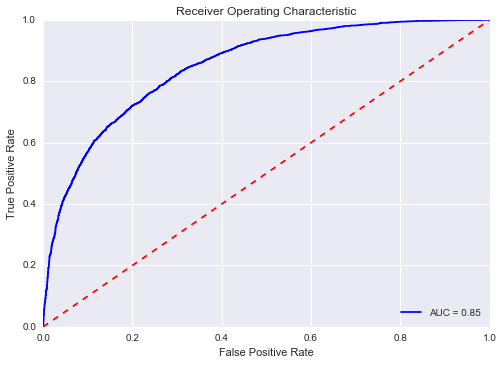

Best Estimator:KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=56, p=2,
           weights='distance')
Accuracy score: 0.741011487394
CV AUC [ 0.83156653  0.81218288  0.8366828   0.80169204  0.80584971], Average AUC 0.817594793591


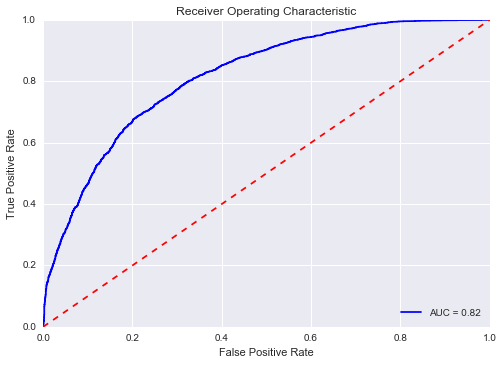

Best Estimator:RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=95, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy score: 0.793077726391
CV AUC [ 0.84706805  0.84701763  0.86754042  0.8266878   0.82231501], Average AUC 0.842125780585


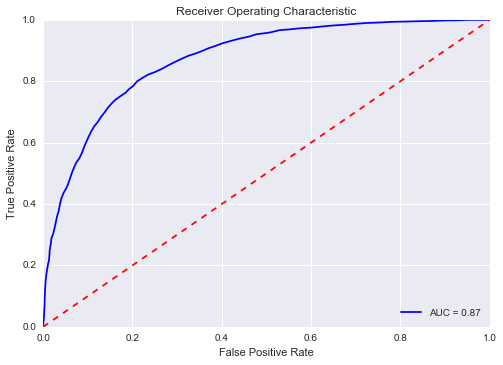

In [45]:
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import roc_curve, auc

models = [LogisticRegression(), KNeighborsClassifier(), RandomForestClassifier()]
params = [{'C': np.linspace(3, 5, 20)}, 
          {'n_neighbors':list(range(1,60,5)), 'weights':['uniform', 'distance']}, 
          {'n_estimators': list(range(50,100,3)), 'max_features': ['auto', 'sqrt', 'log2']}]
#cv = ShuffleSplit(X_train.shape[0], n_iter=6, test_size=0.2, random_state=0)
#kf=cross_validation.KFold(n=len(X), n_folds=5, shuffle=True)

scores = {'Best Score': [], 'Best Estimator': []}

#find the best estimator for each model
for model, param in zip(models, params):
    gs = grid_search.GridSearchCV(model, param_grid=param, cv=5, scoring='roc_auc', n_jobs=-1)
    gs.fit(X_train, y_train)         
    print 'Best Estimator:{}'.format(gs.best_estimator_)
    # print 'Best Score:{}'.format(gs.best_score_)
    scores['Best Score'].append(gs.best_score_)
    scores['Best Estimator'].append(gs.best_estimator_)
    best = gs.best_estimator_.fit(X_train,y_train)
    print 'Accuracy score:', best.score(X_test, y_test) #accuracy score
    cvs = cross_validation.cross_val_score(best, X, y, scoring='roc_auc', cv=5, n_jobs=-1)
    print('CV AUC {}, Average AUC {}'.format(cvs, cvs.mean()))
    
    roc_curve_plt(best, y_test, pred_proba)

    print '============================================================================================='

RandomForestClassifier model performed the best